In [1]:
from sklearnex import patch_sklearn

patch_sklearn()

import pickle
import sys
sys.path.insert(0,'..')
import module as mod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer

from lightgbm import LGBMClassifier, Dataset, train, log_evaluation
import optuna

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Importation du jeu de données
Le jeu de données UKDale était échantillonné à la minute, nous allons re-échantillonner nos jeu de données avec la même fréquence.

In [2]:
house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip', resample_period='1min')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.000000
2016-03-06 00:01:00,476.0,0,0.016667
2016-03-06 00:02:00,477.0,0,0.033333
2016-03-06 00:03:00,474.0,0,0.050000
2016-03-06 00:04:00,479.0,0,0.066667


In [3]:
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip', resample_period='1min')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.000000
2017-09-12 23:01:00,102.0,0,23.016667
2017-09-12 23:02:00,104.0,0,23.033333
2017-09-12 23:03:00,106.0,0,23.050000
2017-09-12 23:04:00,110.0,0,23.066667


In [4]:
house2_power_ukdale = mod.load_dataset('ukdale/house2_power_labels.zip', resample_period='1min')
house2_power_ukdale.head()

,mains,activity,hour
datetime,,,
2013-05-20 21:28:00,92.60000,0.0,21.466667
2013-05-20 21:29:00,250.18333,0.0,21.483333
2013-05-20 21:30:00,248.18333,0.0,21.500000
2013-05-20 21:31:00,252.88333,0.0,21.516667
2013-05-20 21:32:00,250.60000,0.0,21.533333


In [5]:
# we generate our features
windows = ['1h', '10min']
features_col = ['mains', 'hour']

house1_power_blk2, _ = mod.generate_features(house1_power_blk2, window=windows)
house2_power_blk1, _ = mod.generate_features(house2_power_blk1, window=windows)
house2_power_ukdale, cols = mod.generate_features(house2_power_ukdale, window=windows)
features_col += cols

In [21]:
# train / test split
X_train_h1, y_train_h1 = house1_power_blk2[features_col].values, house1_power_blk2["activity"].values
X_train_h2, y_train_h2 = house2_power_blk1[features_col].values, house2_power_blk1["activity"].values


train_df_h2_ukd, test_df_h2_ukd = mod.train_test_split_dataset(house2_power_ukdale, 0.8)
X_train_h2_ukd, y_train_h2_ukd = train_df_h2_ukd[features_col].values, train_df_h2_ukd["activity"].values
X_test_h2_ukd, y_test_h2_ukd = test_df_h2_ukd[features_col].values, test_df_h2_ukd["activity"].values

In [22]:
# mise à l'échelle des données
scaler = MinMaxScaler()
X_train_h1 = scaler.fit_transform(X_train_h1)
X_train_h2 = scaler.fit_transform(X_train_h2)

X_train_h2_ukd = scaler.fit_transform(X_train_h2_ukd)
X_test_h2_ukd = scaler.transform(X_test_h2_ukd)

In [23]:
# on regroupe les données de la maison 1 + 2 et on shuffle
X_train_h12 = np.append(X_train_h1, X_train_h2, axis=0)
y_train_h12 = np.append(y_train_h1, y_train_h2, axis=0)
train_idx = np.random.choice(X_train_h12.shape[0],  X_train_h12.shape[0], replace=False)
X_train_h12 = X_train_h12[train_idx, :]
y_train_h12 = y_train_h12[train_idx]

X_train_h12.shape, y_train_h12.shape

((175680, 11), (175680,))

## Maisons 1+2 vs UKDale maison 2

In [24]:
# entrainement du modèle sur la maison 1+2
dtrain_h12 = Dataset(X_train_h12, label=y_train_h12)
best_params = {'lambda_l1': 6.997872599114091e-08,
              'lambda_l2': 3.106939695465658,
              'num_leaves': 21,
              'feature_fraction': 0.7749089992945499,
              'bagging_fraction': 0.8304216244979004,
              'bagging_freq': 4,
              'min_child_samples': 92
              }

gbm = train({**best_params, 'verbosity': -1}, dtrain_h12, callbacks=[log_evaluation(0)])

Score f_beta : 70.547%
Score accuracy : 77.615%
true positive rate: 94.82%, false positive rate: 11.95%


/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Classification/../module.py:529: RuntimeWarning: invalid value encountered in double_scalars
  IoU = I/U


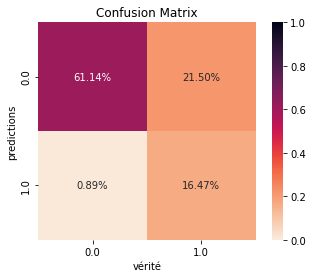

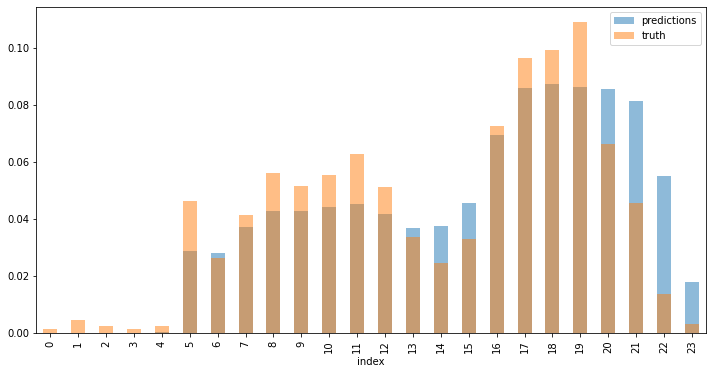

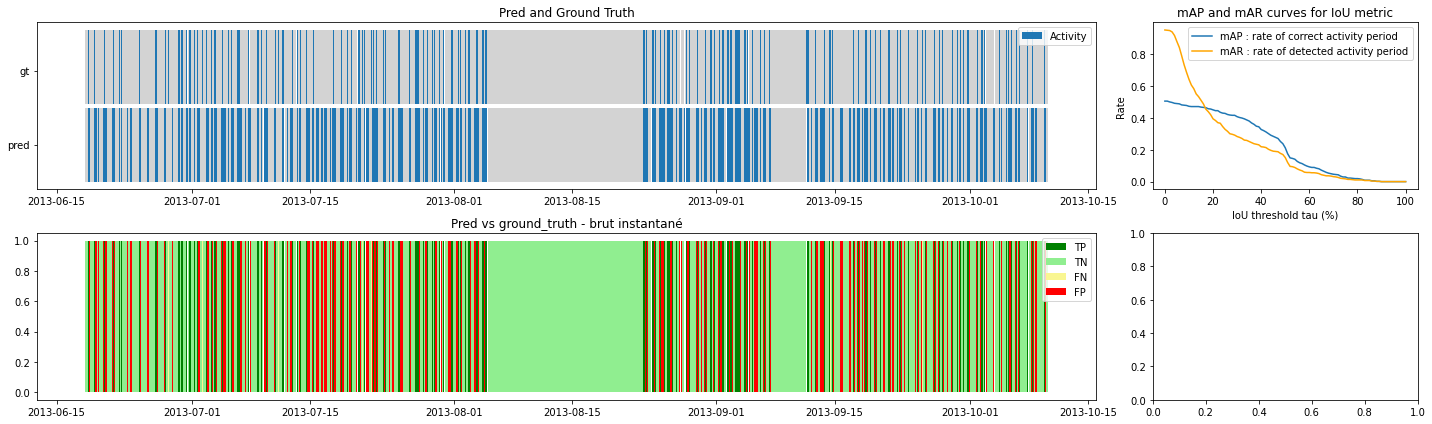

In [25]:
y_pred_h2_ukd = gbm.predict(X_test_h2_ukd)
y_pred_h2_ukd = np.rint(y_pred_h2_ukd)

mod.plot_confusion_matrix(y_test_h2_ukd, y_pred_h2_ukd);

house2_power_ukdale_res = house2_power_ukdale.copy()
house2_power_ukdale_res['activity_pred'] = np.nan
house2_power_ukdale_res.iloc[-X_test_h2_ukd.shape[0]:, -1] = (y_pred_h2_ukd).astype(int)
activity_pred_h2_ukd = house2_power_ukdale_res['activity_pred'].iloc[-X_test_h2_ukd.shape[0]:]
activity_true_h2_ukd = house2_power_ukdale['activity'].iloc[-X_test_h2_ukd.shape[0]:]

fig, ax = plt.subplots()
mod.plot_activity_hist(activity_pred_h2_ukd, figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(activity_true_h2_ukd, figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

TPR, FPR = mod.score_overlap(activity_true_h2_ukd, activity_pred_h2_ukd)
print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

# plot the confusion metric
pred = pd.DataFrame()
df_gt = pd.DataFrame()

pred[['timestamp', 'activity_prediction']] = house2_power_ukdale_res.reset_index()[['datetime', 'activity_pred']].iloc[-X_test_h2_ukd.shape[0]:]
df_gt[['timestamp', 'activity_true']] = house2_power_ukdale.reset_index()[['datetime', 'activity']].iloc[-X_test_h2_ukd.shape[0]:]
mod.eval_metric(pred, df_gt);